<a href="https://colab.research.google.com/github/MartaCampagnoli/HateSpeechDetection/blob/main/Output%20Notebooks/Classification_Part2_MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gensim
import io
import pandas as pd
import numpy as np
import re
import string
import nltk
import gensim.downloader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from google.colab import files
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras import utils
from keras import models, layers, callbacks, regularizers
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=d275127e39fc964e78c629064c86289f8b852ba5b7f87c02d9d7a65dbfe0af0d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stemmer = nltk.SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
uploaded = files.upload() #sixcat.csv

Saving sixcat.csv to sixcat.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['sixcat.csv'])) #sixcat

In [ ]:
train, test = train_test_split(df ,test_size=0.30, random_state = 42)

In [ ]:
#modify stopwords list and preprocess data
stopwords = nltk.corpus.stopwords.words('english')
exceptions = ["no", "not" , "don't", "they", "them"]
stop_words = [word for word in stopwords if word not in exceptions]


def preprocess(text):
    text = ''.join([word for word in text])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return ' '.join(tokens)

In [ ]:
#Training plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    #Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)
    plt.grid()

    #Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)
    plt.grid()

    plt.show()

earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)
loss = keras.losses.CategoricalCrossentropy()

# Defining the network structures

In [ ]:
def evaluatemodel(model):
  model.evaluate(X_test300, y_test)
  y_pred = model.predict(X_test300)
  y_pred = np.argmax(y_pred, axis=1)
  return  y_pred

In [ ]:
#cnn
def deepcnn(vocab_size, embedding_matrix, num_class):
  model = Sequential()
  model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(MaxPooling1D(3, padding='same'))
  model.add(Dropout(0.5))
  model.add(Conv1D(128, 3, padding="same", activation='relu'))
  model.add(Conv1D(128, 3, padding="same", activation='relu'))
  model.add(Conv1D(128, 3, padding="same", activation='relu'))
  model.add(MaxPooling1D(3, padding='same'))
  model.add(Dropout(0.4))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(Conv1D(64, 3, padding="same", activation='relu'))
  model.add(MaxPooling1D(3, padding='same'))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_class, activation = 'softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  return model

#bilstm

def bidlstm(vocab_size, embedding_matrix, num_class):
  model = Sequential()
  model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
  model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
  model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
  model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
  model.add(Dropout(0.4))
  model.add(Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
  model.add(Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
  model.add(Bidirectional(tf.keras.layers.LSTM(32)))
  model.add(Dropout(0.2))
  model.add(Dense(num_class, activation = 'softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  return model

# Pretrained embeddings: CNN and Bidirectional


In [ ]:
#setting training and test
X_train, X_test, train_target, test_target = train['text'], test['text'], train['target'], test['target']

In [ ]:
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [ ]:
#encoding the labels and saving the number of classes as a variable
encoder = LabelEncoder()
encoder.fit(train_target)
y_train = encoder.transform(train_target)
y_test = encoder.transform(test_target)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [ ]:
#tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
max_length = 300
X_train300 = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test300 = pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:
#function to try for pretrained models
def embedpretr(model, token):
  embedding_matrix = np.zeros((vocab_size, 300))
  for word, i in token.word_index.items():
    if word in model:
        embedding_matrix[i] = model[word]
  return embedding_matrix

In [ ]:
#Available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
w2vvectors = gensim.downloader.load('word2vec-google-news-300')
fast = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
embedding_matrix_pre = embedpretr(w2vvectors, tokenizer)

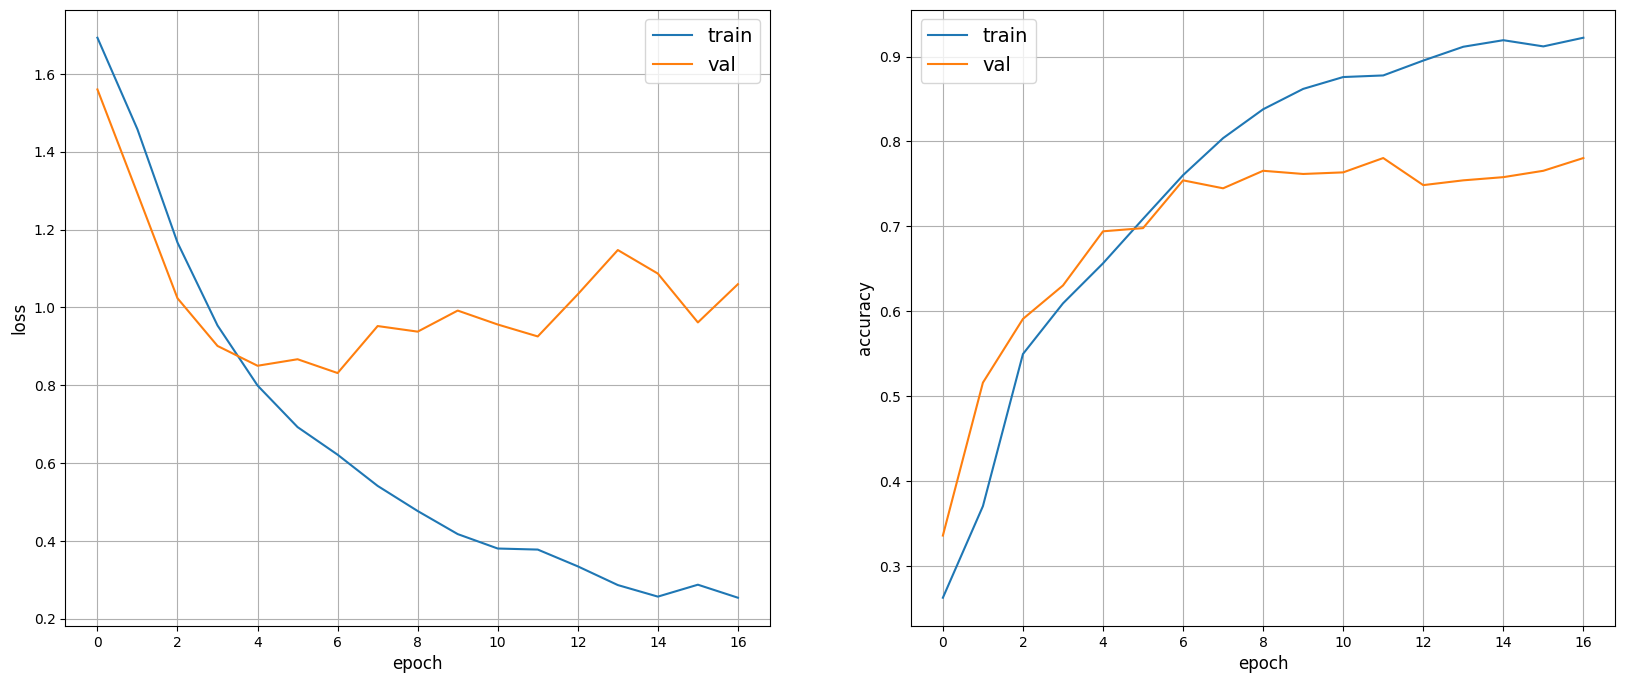

In [ ]:
#cnn with pretrained w2c
pretrainedcnnw = deepcnn(vocab_size, embedding_matrix_pre, num_classes)
history = pretrainedcnnw.fit(X_train300, y_train, epochs=50, batch_size=128, verbose = 0, validation_split=0.1, callbacks=[earlystopping])
performance_plot(history)

In [ ]:
#evaluating the cnn
predictions = evaluatemodel(pretrainedcnnw)

72/72 [==============================] - 1s 4ms/step


              precision    recall  f1-score   support

           0       0.84      0.86      0.85       590
           1       0.46      0.59      0.51       222
           2       0.94      0.68      0.79       334
           3       0.73      0.75      0.74       299
           4       0.44      0.52      0.48       217
           5       0.88      0.84      0.86       621

    accuracy                           0.76      2283
   macro avg       0.72      0.71      0.71      2283
weighted avg       0.78      0.76      0.76      2283



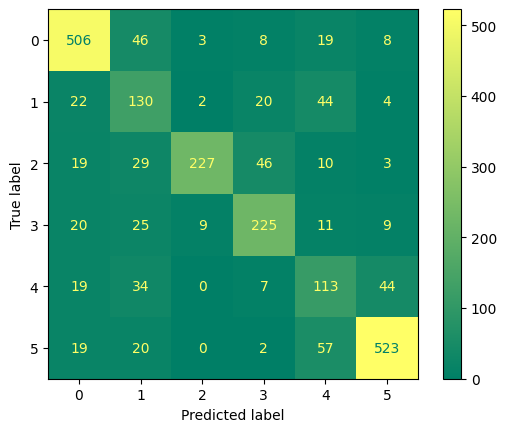

In [ ]:
print(metrics.classification_report(test_target, predictions))
ConfusionMatrixDisplay.from_predictions(test_target, predictions, cmap = 'summer')

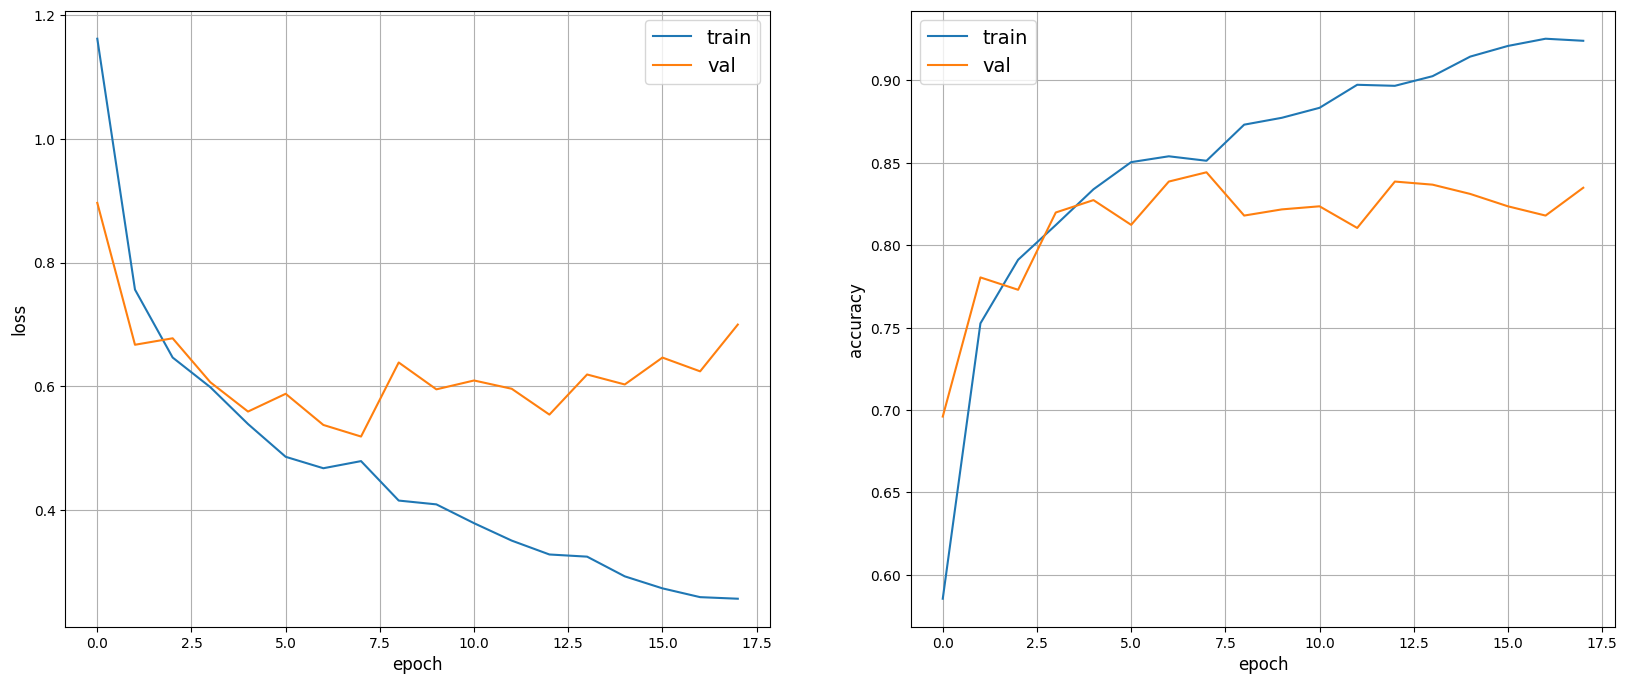

In [ ]:
pretrainedlstmw = bidlstm(vocab_size, embedding_matrix_pre, num_classes)
history = pretrainedlstmw.fit(X_train300, y_train, epochs=50, batch_size=32, verbose = 0, validation_split=0.1, callbacks=[earlystopping])
performance_plot(history)

In [ ]:
predictions = evaluatemodel(pretrainedlstmw)

72/72 [==============================] - 7s 46ms/step


              precision    recall  f1-score   support

           0       0.91      0.85      0.88       590
           1       0.79      0.70      0.74       222
           2       0.92      0.80      0.86       334
           3       0.79      0.86      0.82       299
           4       0.48      0.65      0.56       217
           5       0.87      0.88      0.87       621

    accuracy                           0.82      2283
   macro avg       0.79      0.79      0.79      2283
weighted avg       0.83      0.82      0.82      2283



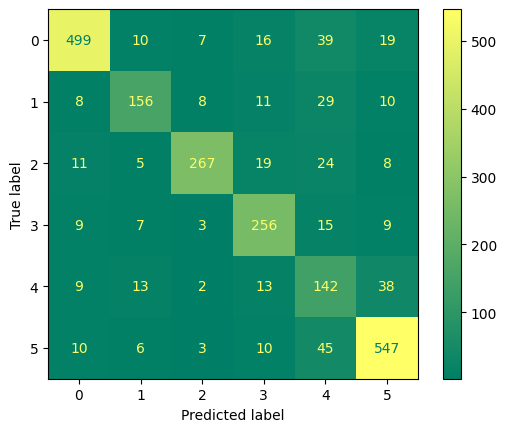

In [ ]:
print(metrics.classification_report(test_target, predictions))
ConfusionMatrixDisplay.from_predictions(test_target, predictions, cmap = 'summer')

In [ ]:
#fasttext

In [ ]:
embedding_matrix_pref = embedpretr(fast, tokenizer)

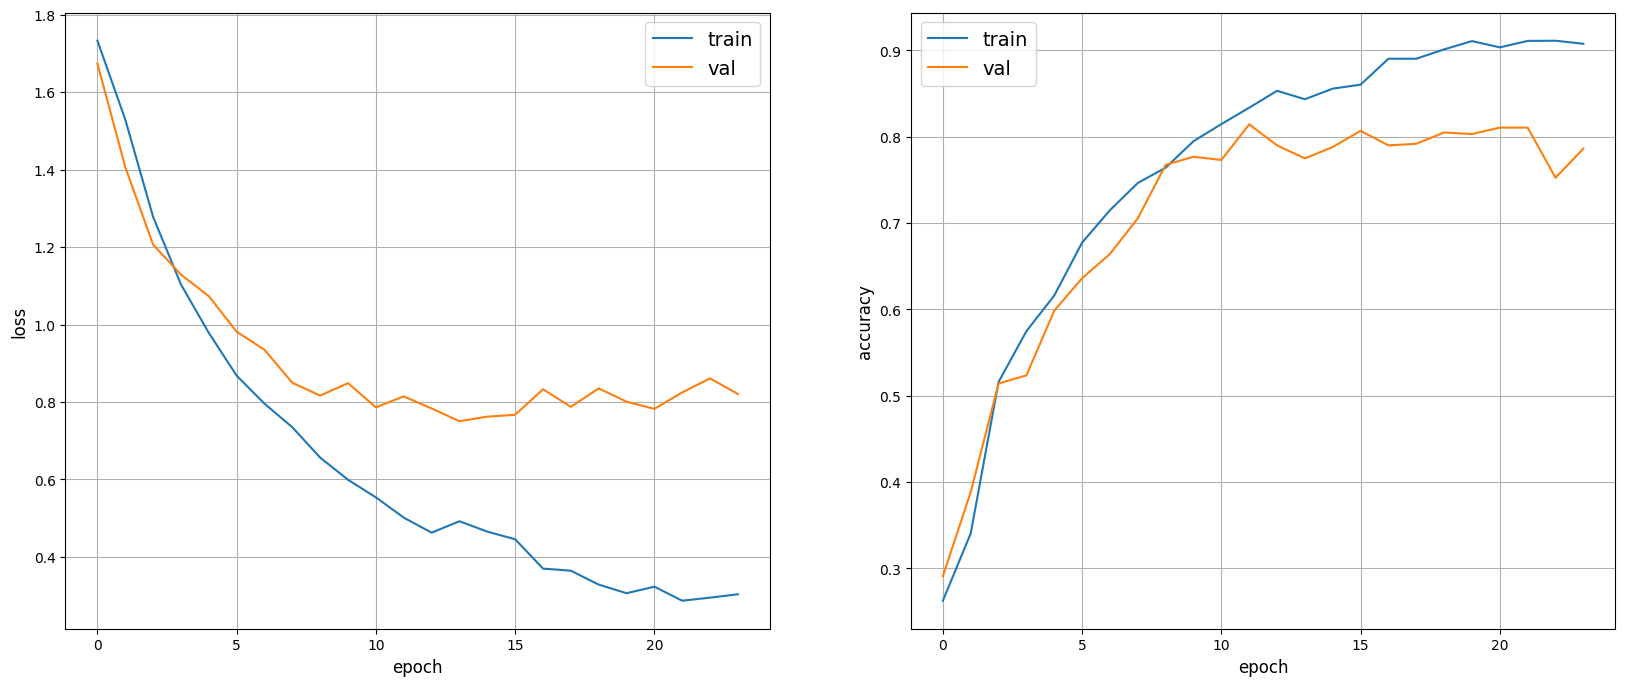

In [ ]:
pretrainedcnnf = deepcnn(vocab_size, embedding_matrix_pref, num_classes)
history = pretrainedcnnf.fit(X_train300, y_train, epochs=50, batch_size=128, verbose = 0, validation_split=0.1, callbacks=[earlystopping])
performance_plot(history)

In [ ]:
predictions = evaluatemodel(pretrainedcnnf)

72/72 [==============================] - 1s 4ms/step


              precision    recall  f1-score   support

           0       0.90      0.80      0.85       590
           1       0.62      0.72      0.67       222
           2       0.97      0.73      0.84       334
           3       0.81      0.82      0.81       299
           4       0.35      0.73      0.47       217
           5       0.94      0.76      0.84       621

    accuracy                           0.77      2283
   macro avg       0.77      0.76      0.75      2283
weighted avg       0.83      0.77      0.79      2283



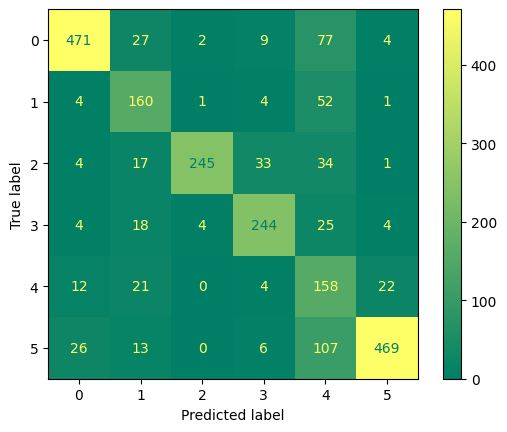

In [ ]:
print(metrics.classification_report(test_target, predictions))
ConfusionMatrixDisplay.from_predictions(test_target, predictions, cmap = 'summer')

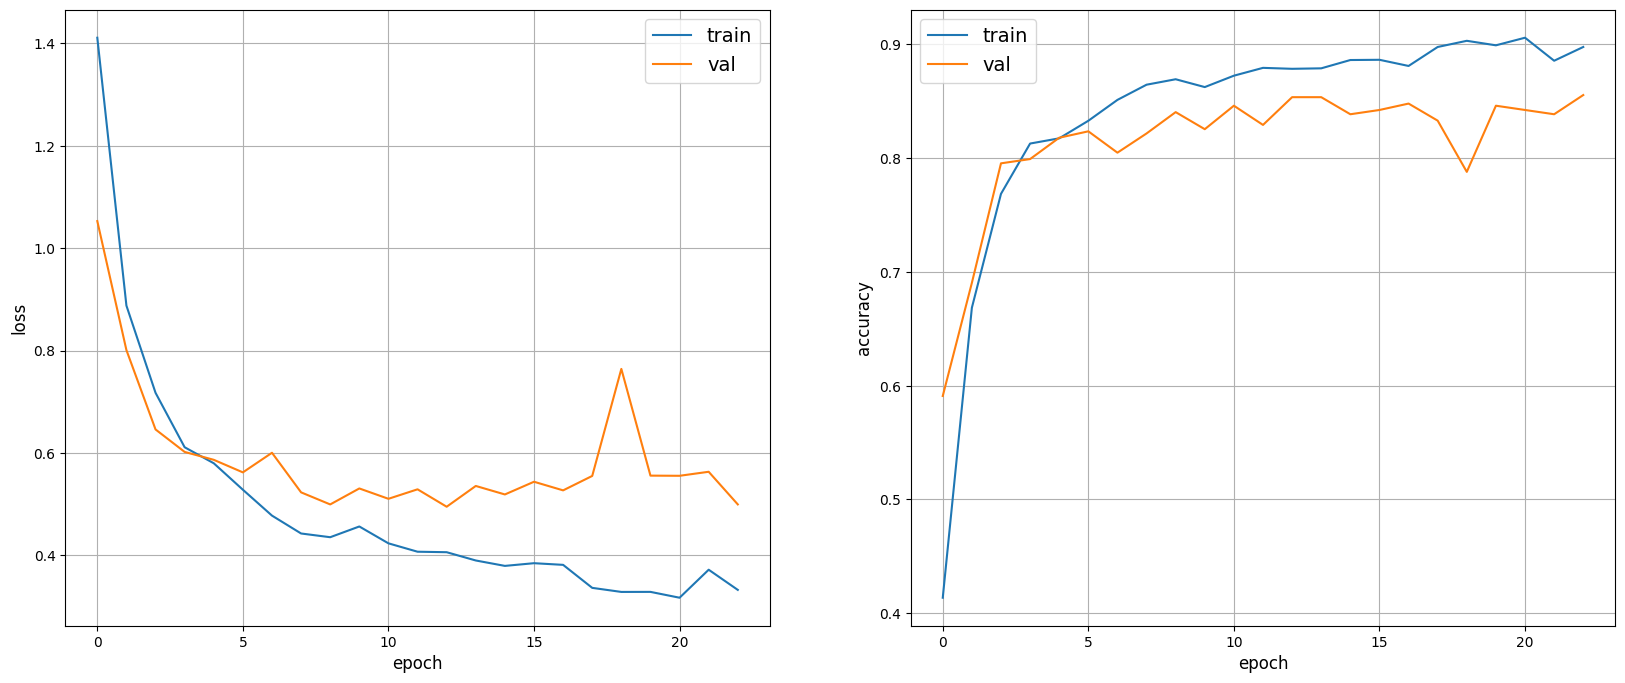

In [ ]:
pretrainedlstmf = bidlstm(vocab_size, embedding_matrix_pref, num_classes)
history = pretrainedlstmf.fit(X_train300, y_train, epochs=50, batch_size=32, verbose = 0, validation_split=0.1, callbacks=[earlystopping])
performance_plot(history)

In [ ]:
predictions = evaluatemodel(pretrainedlstmf)

72/72 [==============================] - 8s 56ms/step


              precision    recall  f1-score   support

           0       0.88      0.87      0.87       590
           1       0.89      0.75      0.81       222
           2       0.86      0.85      0.86       334
           3       0.87      0.85      0.86       299
           4       0.49      0.67      0.56       217
           5       0.90      0.85      0.88       621

    accuracy                           0.83      2283
   macro avg       0.81      0.81      0.81      2283
weighted avg       0.84      0.83      0.83      2283



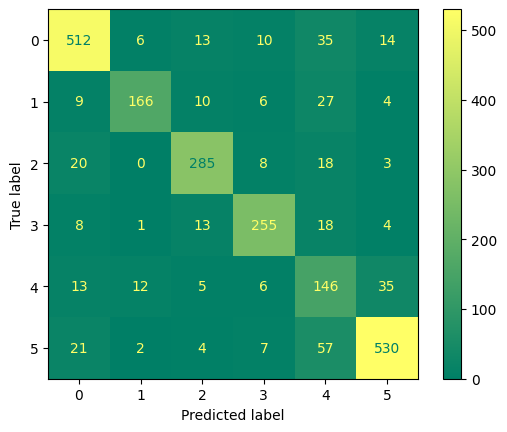

In [ ]:
print(metrics.classification_report(test_target, predictions))
ConfusionMatrixDisplay.from_predictions(test_target, predictions, cmap = 'summer')